# Simple CNN binary classifier

In [1]:
import cv2
import os
import numpy as np 
import matplotlib.pyplot as plt
import glob

import tensorflow as tf

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Activation, MaxPooling2D, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Nadam, Adam, SGD
from tensorflow.keras import backend as K

from sklearn.metrics import classification_report, precision_score , recall_score

In [2]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
# index-class mapping
MAP_CLASSES = {
    0: 'off', 1: 'on'
}

# img size standardized to 64x64
IMG_SIZE = 64

In [4]:
def load_train_set(dirname, map_classes, verbose=True):
    """Load train images.
    
    Use opencv to resize the images.
    
    Args:
        dirname: directory to read data from (one folder per class)
        map_classes: mapping variables e.g. {0: 'class_1, 1: 'class_2'}
        verbose: print info at the end
     
    Returns:
        X, y: X is an array with all the images resized
              y is an array with the labels
    """
    X_train = []
    y_train = []
    for label, class_name in map_classes.items():        
        files = os.listdir(os.path.join(dirname, class_name))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Reading {} train images for class {}".format(len(images), class_name))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, class_name, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [5]:
def load_test_set(dirname, map_classes, verbose=True):
    """ Equivalent as above function, but imaged do not have to be in class folders
        Label is taken from file name e.g. on_0.jpg, off_3.jpg
    """
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_classes.items()}
    for filename in glob.glob(dirname + '/*.*'):
    #for filename in glob.glob('dataset/test/**/*.jpg'):
        class_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if class_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[class_name])
    if verbose:
        print("Reading {} test pictures".format(len(X_test)))
    return np.array(X_test), np.array(y_test)

In [6]:
DATASET_TRAIN_PATH = "dataset/train"
DATASET_TEST_PATH = "dataset/test"

X, y = load_train_set(DATASET_TRAIN_PATH, MAP_CLASSES)
X_t, y_t = load_test_set(DATASET_TEST_PATH, MAP_CLASSES)

Reading 750 train images for class off
Reading 750 train images for class on
Reading 500 test pictures


In [7]:
# Shuffle data since images are read sequentially
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

In [8]:
def plot_acc(history, title="Model Accuracy"):
    """Plots accuracy per epoch"""
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Plots loss per epoch"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1",
                        name2="Red 2", title="Graph title"):
    """Compares 2 train losses"""
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    """Compares 2 train accuracies"""
    plt.plot(history1.history['accuracy'], color="green")
    plt.plot(history1.history['val_accuracy'], 'r--', color="green")
    plt.plot(history2.history['accuracy'], color="blue")
    plt.plot(history2.history['val_accuracy'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()
    
# To change plot size
# matplotlib.rcParams['figure.figsize'] = [8, 8]

In [9]:
X.shape

(1500, 64, 64, 3)

In [10]:
y.shape

(1500,)

In [11]:
print('Button ', y[4], ' is ', MAP_CLASSES[y[4]])

Button  1  is  on


In [12]:
def visualize_example(x):
    plt.figure()
    plt.imshow(x)
    plt.colorbar()
    plt.grid(False)
    plt.show()

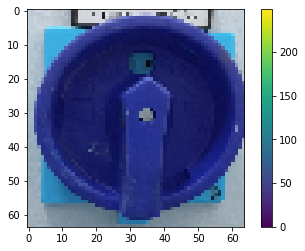

In [13]:
visualize_example(X[4])

In [14]:
# pixel normalization
X = X / 255.0
X_t = X_t / 255.0

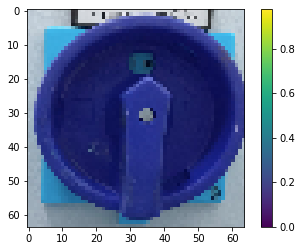

In [15]:
visualize_example(X[4])

In [16]:
batch_size = 64
num_classes = 2

In [17]:
# Data preparation
y = tf.keras.utils.to_categorical(y, num_classes)
y_t = tf.keras.utils.to_categorical(y_t, num_classes)

X = X.astype('float32')
X_t = X_t.astype('float32')

In [18]:
X_t.shape

(500, 64, 64, 3)

In [19]:
y_t.shape

(500, 2)

## Modelo 1

In [20]:
#lr = 0.001
#epochs = 40

#model = Sequential()

#model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(64,64,3), name='input')) #, input_shape=(64,64,3)
#model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))

#model.add(MaxPooling2D(pool_size=(2,2))) 
#model.add(BatchNormalization())
#model.add(Dropout(0.4))

#model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
#model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))

#model.add(MaxPooling2D(pool_size=(2,2))) 
#model.add(BatchNormalization())
#model.add(Dropout(0.6))

#model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
#model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))

#model.add(MaxPooling2D(pool_size=(2,2))) 
#model.add(BatchNormalization())
#model.add(Dropout(0.6))

#model.add(Flatten())
#model.add(Dense(1024, activation='relu'))
#model.add(Dropout(0.7))
#model.add(Dense(128, activation='relu'))

# model.add(Dense(2, activation='softmax', name="output"))  # 2 categories  

#
# 92% in validation, 97% in test
#

#model.summary()

In [21]:
#adam = Adam(lr=lr)

#es = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
#mc = ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True)

#model.compile(loss='binary_crossentropy',
#             optimizer=adam,
#             metrics=['accuracy'])

# Entrenamos el modelo con 20% de validación del training
#history = model.fit(X, y,
#                   batch_size = batch_size,
#                   epochs=epochs,
#                   verbose=1,
#                   validation_split = 0.2,
#                   callbacks=[es, mc])  #Vamos a gastar el 20% del training como validación

## Modelo 2 [Machine Learning Mastery](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/)

In [22]:
lr = 0.001
epochs = 40

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(64, 64, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(2, activation='softmax'))

# compile model
# opt = SGD(lr=lr, momentum=0.9)
opt = Nadam(lr=lr)

# model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0

In [24]:
mc = ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True)

# 20% validation from train data
history = model.fit(X, y,
                   batch_size = batch_size,
                   epochs=epochs,
                   verbose=1,
                   validation_split = 0.2,
                   callbacks=[mc])

Epoch 1/40
19/19 [==============================] - 6s 261ms/step - loss: 1.3864 - accuracy: 0.7083 - f1_m: 0.7085 - precision_m: 0.7085 - recall_m: 0.7085 - val_loss: 0.3735 - val_accuracy: 0.9967 - val_f1_m: 0.9969 - val_precision_m: 0.9969 - val_recall_m: 0.9969

Epoch 00001: val_loss improved from inf to 0.37350, saving model to best_model.h5
Epoch 2/40
19/19 [==============================] - 4s 200ms/step - loss: 0.2162 - accuracy: 1.0000 - f1_m: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 0.0129 - val_accuracy: 1.0000 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000

Epoch 00002: val_loss improved from 0.37350 to 0.01291, saving model to best_model.h5
Epoch 3/40
19/19 [==============================] - 4s 200ms/step - loss: 0.0072 - accuracy: 1.0000 - f1_m: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000

Epoch 00003: val_loss improved 

## Plots and stuff

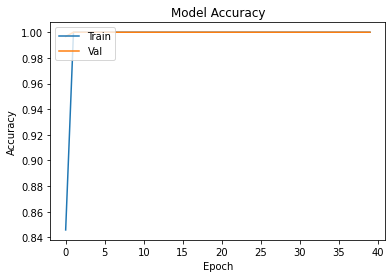

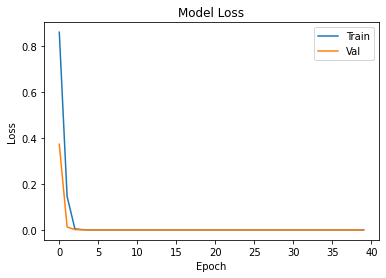

In [25]:
plot_acc(history)
plot_loss(history)

In [26]:
score = model.evaluate(X_t, y_t, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 3.6550343196495305e-08
Test accuracy: 1.0


In [27]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_t, y_t, verbose=0)
print(f"Losss:\t{loss}")
print(f"Acc:\t{accuracy}")
print(f"F1:\t{f1_score}")
print(f"Recall:\t{recall}")

Losss:	3.6550343196495305e-08
Acc:	1.0
F1:	1.0
Recall:	1.0


# Predictions

In [32]:
model = load_model('best_model.h5', custom_objects={'f1_m':f1_m, 'precision_m':precision_m, 'recall_m':recall_m})

In [33]:
def visualize_prediction(x, class_index):
    plt.figure()
    plt.imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
    plt.xlabel(class_index)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [34]:
result = model.predict(X_t[0].reshape(1, 64,64,3))
result

array([[3.511706e-18, 1.000000e+00]], dtype=float32)

In [35]:
predicted_class = MAP_CLASSES[np.argmax(result)]

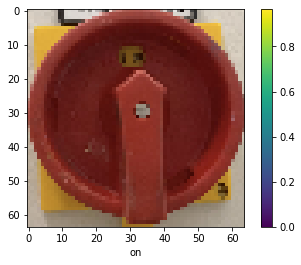

In [44]:
visualize_prediction(X_t[0], predicted_class)

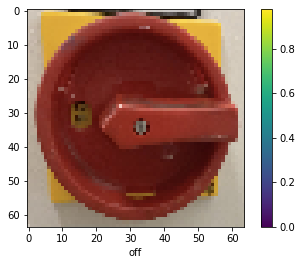

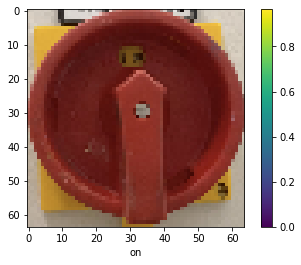

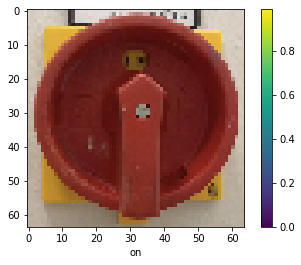

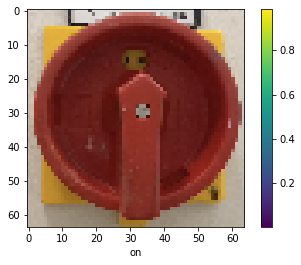

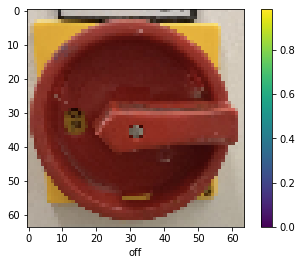

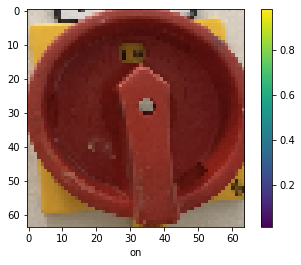

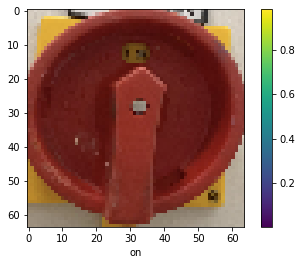

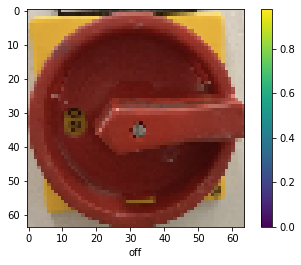

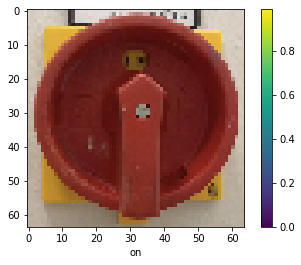

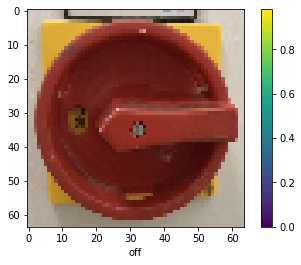

In [45]:
import random

for img in random.sample(list(X_t), 10):
    prediction = MAP_CLASSES[np.argmax(model.predict(img.reshape(1, 64,64,3)))]
    visualize_prediction(img, prediction)